# Seizure Frequency Comparison

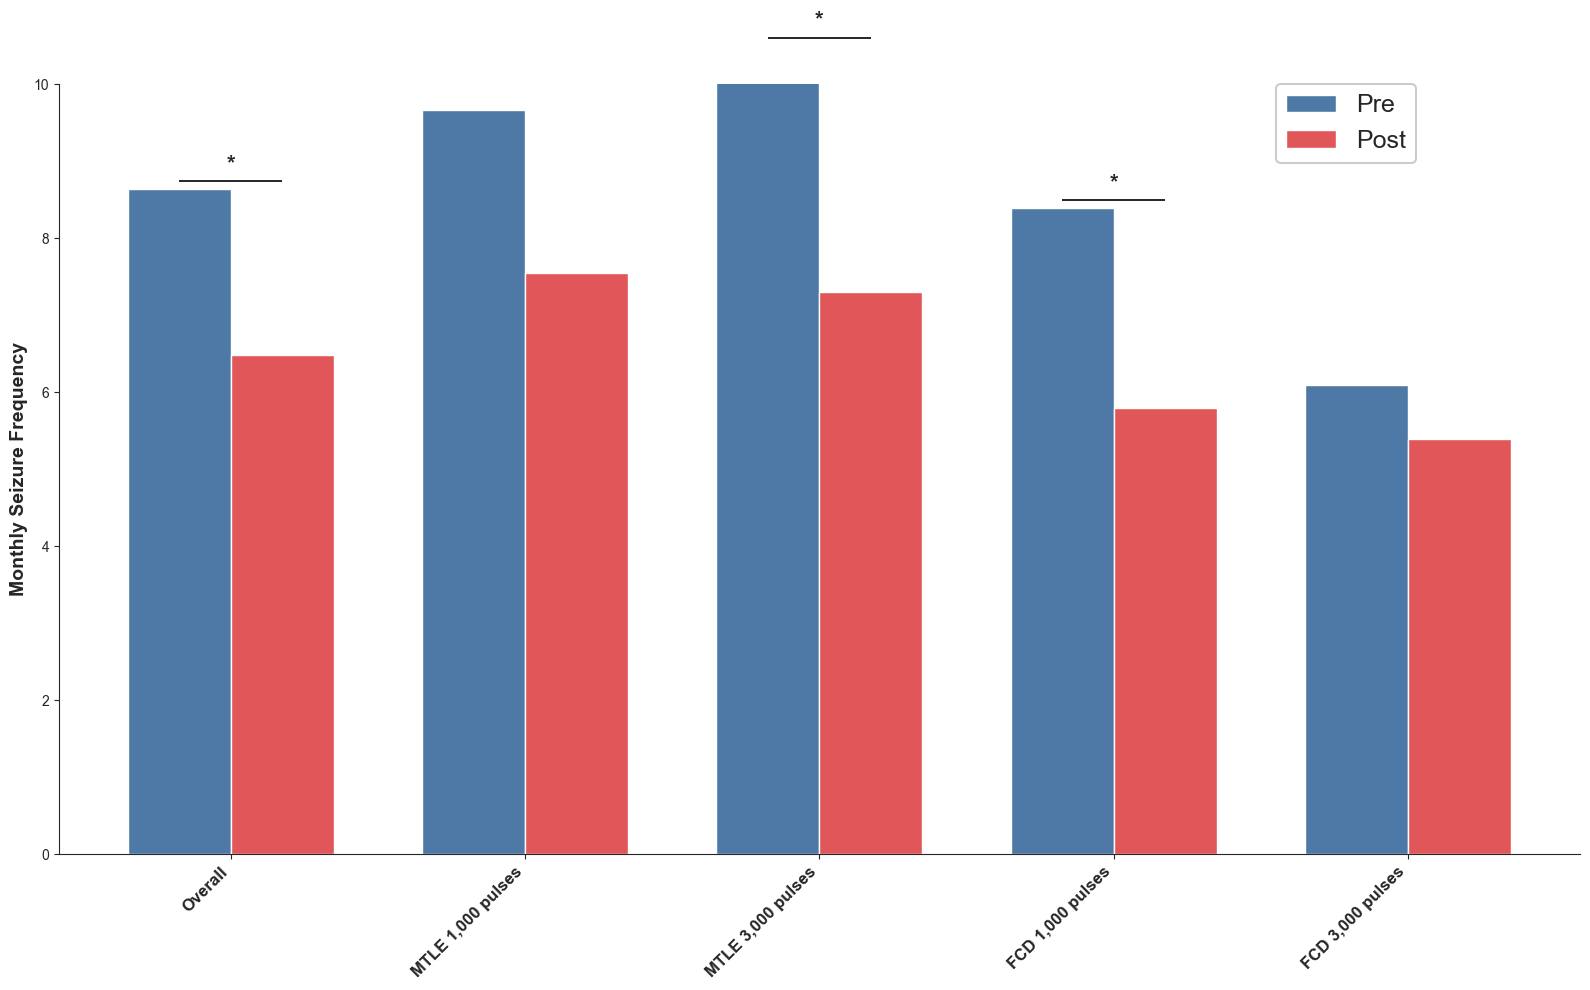

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the data
df = pd.read_csv('data_for_ROI.csv')

# Create the plot with larger figure size for better spacing
plt.figure(figsize=(16, 10))
sns.set_style("ticks")
plt.grid(False)

# Remove top and right spines
sns.despine()

# Define the groups and their labels
groups = [
    {'name': 'Overall', 'condition': (df['etiology'].notna())},
    {'name': 'MTLE 1,000 pulses', 'condition': (df['etiology'] == 'TLE') & (df['Stim_11000_23000'] == 1)},
    {'name': 'MTLE 3,000 pulses', 'condition': (df['etiology'] == 'TLE') & (df['Stim_11000_23000'] == 2)},
    {'name': 'FCD 1,000 pulses', 'condition': (df['etiology'] == 'FCD') & (df['Stim_11000_23000'] == 1)},
    {'name': 'FCD 3,000 pulses', 'condition': (df['etiology'] == 'FCD') & (df['Stim_11000_23000'] == 2)}
]

# Set the positions for the bars
x = np.arange(len(groups))
bar_width = 0.35

# Define custom colors
pre_color = '#4e79a7'  # Dark blue
post_color = '#e15759'  # Red

# Get current axis
ax = plt.gca()

# Plot pre and post seizure frequencies
for i, group in enumerate(groups):
    group_data = df[group['condition']]
    
    # Calculate means
    pre_mean = group_data['Pre_seizure_frequency'].mean()
    post_mean = group_data['Post_seizure_frequency'].mean()
    
    # Plot bars
    ax.bar(x[i] - bar_width/2, pre_mean, width=bar_width, color=pre_color, label='Pre' if i == 0 else '')
    ax.bar(x[i] + bar_width/2, post_mean, width=bar_width, color=post_color, label='Post' if i == 0 else '')
    
    # Perform paired t-test if there's enough data
    if len(group_data) >= 2:
        t_stat, p_value = stats.ttest_rel(
            group_data['Pre_seizure_frequency'].dropna(),
            group_data['Post_seizure_frequency'].dropna()
        )
        
        # Add asterisk and connecting line if p < 0.05
        if p_value < 0.05:
            # Get current y-axis limits
            y_min, y_max = ax.get_ylim()
            
            # Calculate positions for the line and asterisk
            max_y = max(pre_mean, post_mean)
            # Set spacing for all specified groups to 0.1
            if i in [0, 2, 3]:  # Overall, MTLE 3,000 pulses, and FCD 1,000 pulses groups
                line_y = max_y + 0.1  # 0.1 spacing for these groups
            else:
                line_y = max_y + 0.1  # Default spacing for other groups
            text_y = line_y * 1.01  # Keep asterisk close to the line
            
            # Ensure the asterisk stays within the plot
            if text_y > y_max * 0.95:  # If too close to the top
                ax.set_ylim(top=y_max * 1.05)  # Minimal increase to y-axis limit
                y_max = y_max * 1.05
            
            # Draw the horizontal line (thinner line)
            ax.hlines(y=line_y, xmin=x[i] - bar_width/2, xmax=x[i] + bar_width/2, 
                    color='black', linewidth=1.2, clip_on=False)
            # Add the asterisk (slightly smaller)
            ax.text(x[i], text_y, '*', ha='center', va='bottom', 
                   fontsize=16, fontweight='bold', clip_on=False)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels([g['name'] for g in groups], rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Seizure Frequency', fontsize=14, fontweight='bold')

# Get the legend and modify its properties
legend = ax.legend(fontsize=12*1.5,  # 1.5 times larger font
                 bbox_to_anchor=(0.8, 1),  # Position at (0.8, 1)
                 loc='upper left',
                 borderaxespad=0.)

# Make the legend box larger
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_alpha(1)

# Ensure only bottom and left spines are visible and styled
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Make the visible spines solid lines
ax.spines['bottom'].set_linestyle('-')
ax.spines['left'].set_linestyle('-')

# Make sure ticks are only on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Adjust layout to make room for x-axis labels
plt.tight_layout()

# Save the figure with higher DPI
plt.savefig('seizure_frequency_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

# Connectivity Visualization

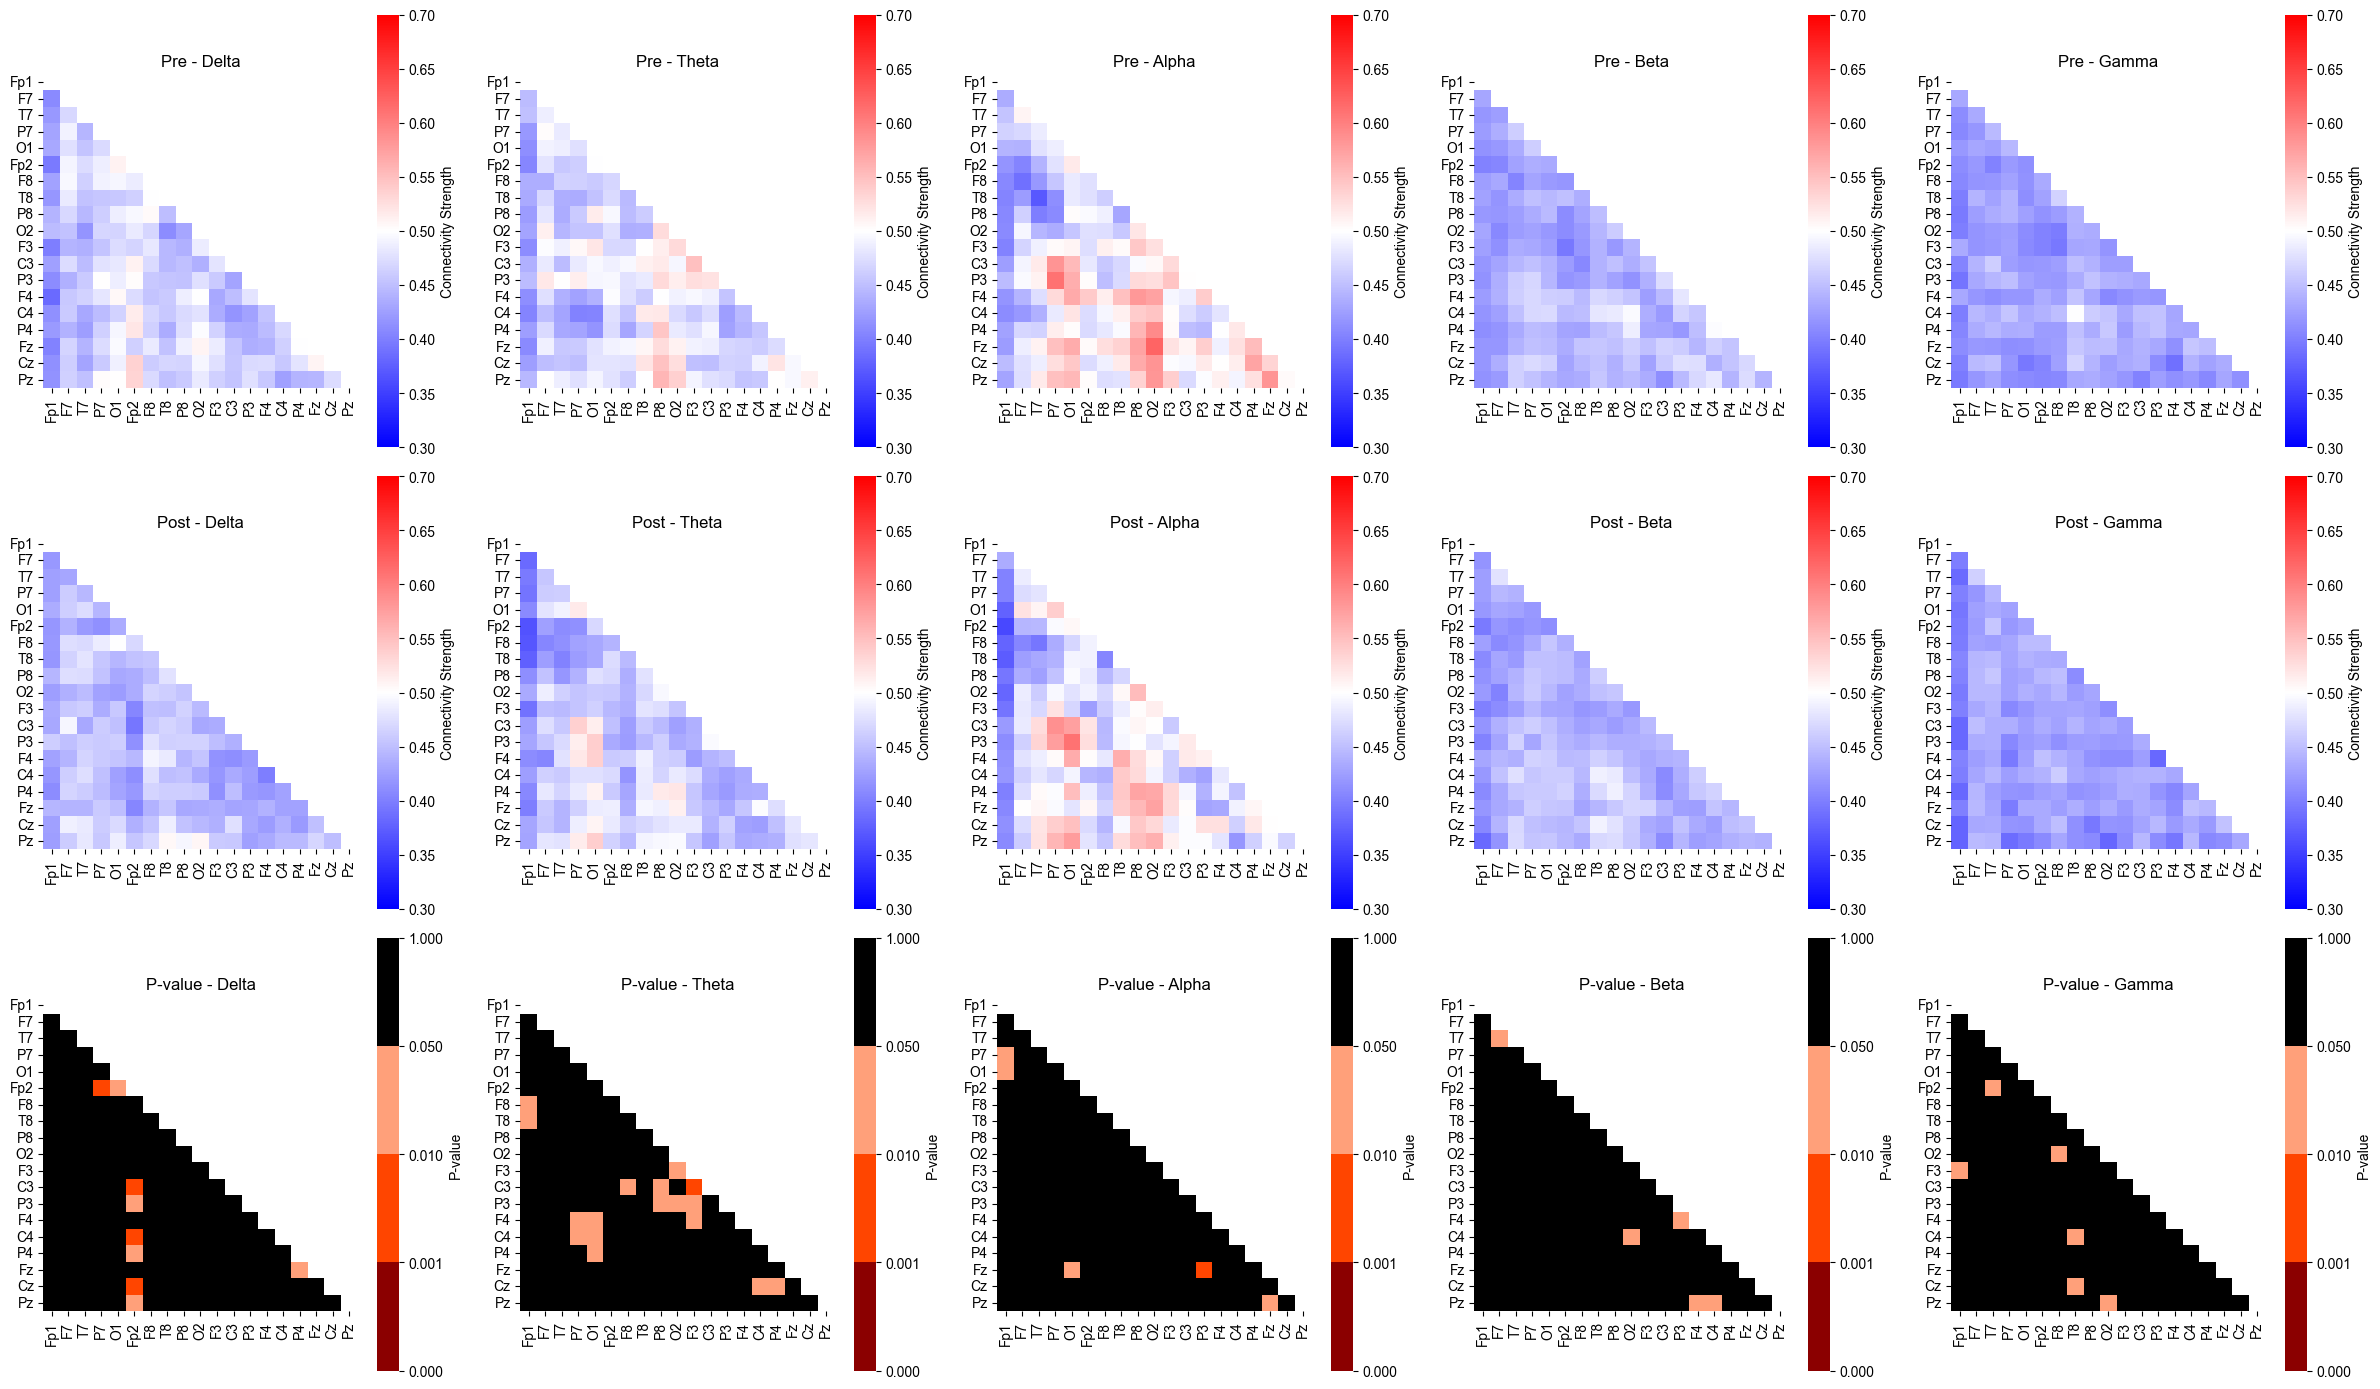

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rcParams

# 글씨체 Arial 설정
rcParams['font.family'] = 'Arial'

# CSV 불러오기
df = pd.read_csv("data_for_area_analysis_raw (1st + 2nd experiment).csv")

# EEG 채널 순서
channels = ['Fp1', 'F7', 'T7', 'P7', 'O1', 'Fp2', 'F8', 'T8', 'P8', 'O2',
            'F3', 'C3', 'P3', 'F4', 'C4', 'P4', 'Fz', 'Cz', 'Pz']
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Responsiveness = 0인 group만 선택 (오타 수정됨)
df_responsive = df.copy()

# 결과 저장용 딕셔너리
adj_matrices_pre = {}
adj_matrices_post = {}
adj_matrices_pval = {}

# 행렬 구성
for band in bands:
    pre_matrix = np.zeros((19, 19))
    post_matrix = np.zeros((19, 19))
    pval_matrix = np.ones((19, 19))

    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            if i > j:
                pre_col = f'pre_{band}-{ch1}-{ch2}' if f'pre_{band}-{ch1}-{ch2}' in df_responsive.columns else f'pre_{band}-{ch2}-{ch1}'
                post_col = f'post_{band}-{ch1}-{ch2}' if f'post_{band}-{ch1}-{ch2}' in df_responsive.columns else f'post_{band}-{ch2}-{ch1}'

                if pre_col in df_responsive.columns and post_col in df_responsive.columns:
                    pre_vals = df_responsive[pre_col]
                    post_vals = df_responsive[post_col]

                    pre_matrix[i, j] = pre_vals.mean()
                    post_matrix[i, j] = post_vals.mean()

                    t_stat, p_val = ttest_rel(pre_vals, post_vals, nan_policy='omit')
                    pval_matrix[i, j] = p_val

    adj_matrices_pre[band] = pre_matrix
    adj_matrices_post[band] = post_matrix
    adj_matrices_pval[band] = pval_matrix

# 색상 정의
pval_cmap = ListedColormap(['#8b0000', '#ff4500', '#ffa07a', 'black'])
pval_norm = BoundaryNorm([0.0, 0.001, 0.01, 0.05, 1.0], ncolors=4)

pre_vmin, pre_vmax = 0.3, 0.7

# 시각화
fig, axs = plt.subplots(3, 5, figsize=(24, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, band in enumerate(bands):
    # Pre matrix
    hm1 = sns.heatmap(adj_matrices_pre[band], xticklabels=channels, yticklabels=channels,
                      cmap='bwr', vmin=pre_vmin, vmax=pre_vmax,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[0, idx], cbar=True, square=True)
    axs[0, idx].set_title(f"Pre - {band}")
    axs[0, idx].tick_params(axis='x', labelrotation=90)
    axs[0, idx].tick_params(axis='y', labelrotation=0)
    hm1.collections[0].colorbar.set_label('Connectivity Strength')

    # Post matrix
    hm2 = sns.heatmap(adj_matrices_post[band], xticklabels=channels, yticklabels=channels,
                      cmap='bwr', vmin=pre_vmin, vmax=pre_vmax,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[1, idx], cbar=True, square=True)
    axs[1, idx].set_title(f"Post - {band}")
    axs[1, idx].tick_params(axis='x', labelrotation=90)
    axs[1, idx].tick_params(axis='y', labelrotation=0)
    hm2.collections[0].colorbar.set_label('Connectivity Strength')

    # P-value matrix
    hm3 = sns.heatmap(adj_matrices_pval[band], xticklabels=channels, yticklabels=channels,
                      cmap=pval_cmap, norm=pval_norm,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[2, idx], cbar=True, square=True)
    axs[2, idx].set_title(f"P-value - {band}")
    axs[2, idx].tick_params(axis='x', labelrotation=90)
    axs[2, idx].tick_params(axis='y', labelrotation=0)
    hm3.collections[0].colorbar.set_label('P-value')

plt.tight_layout()

# EPS 저장
plt.savefig("eeg_connectivity_analysis.eps", format='eps', dpi=300)
plt.show()


# ROI-based Connectivity Visualization

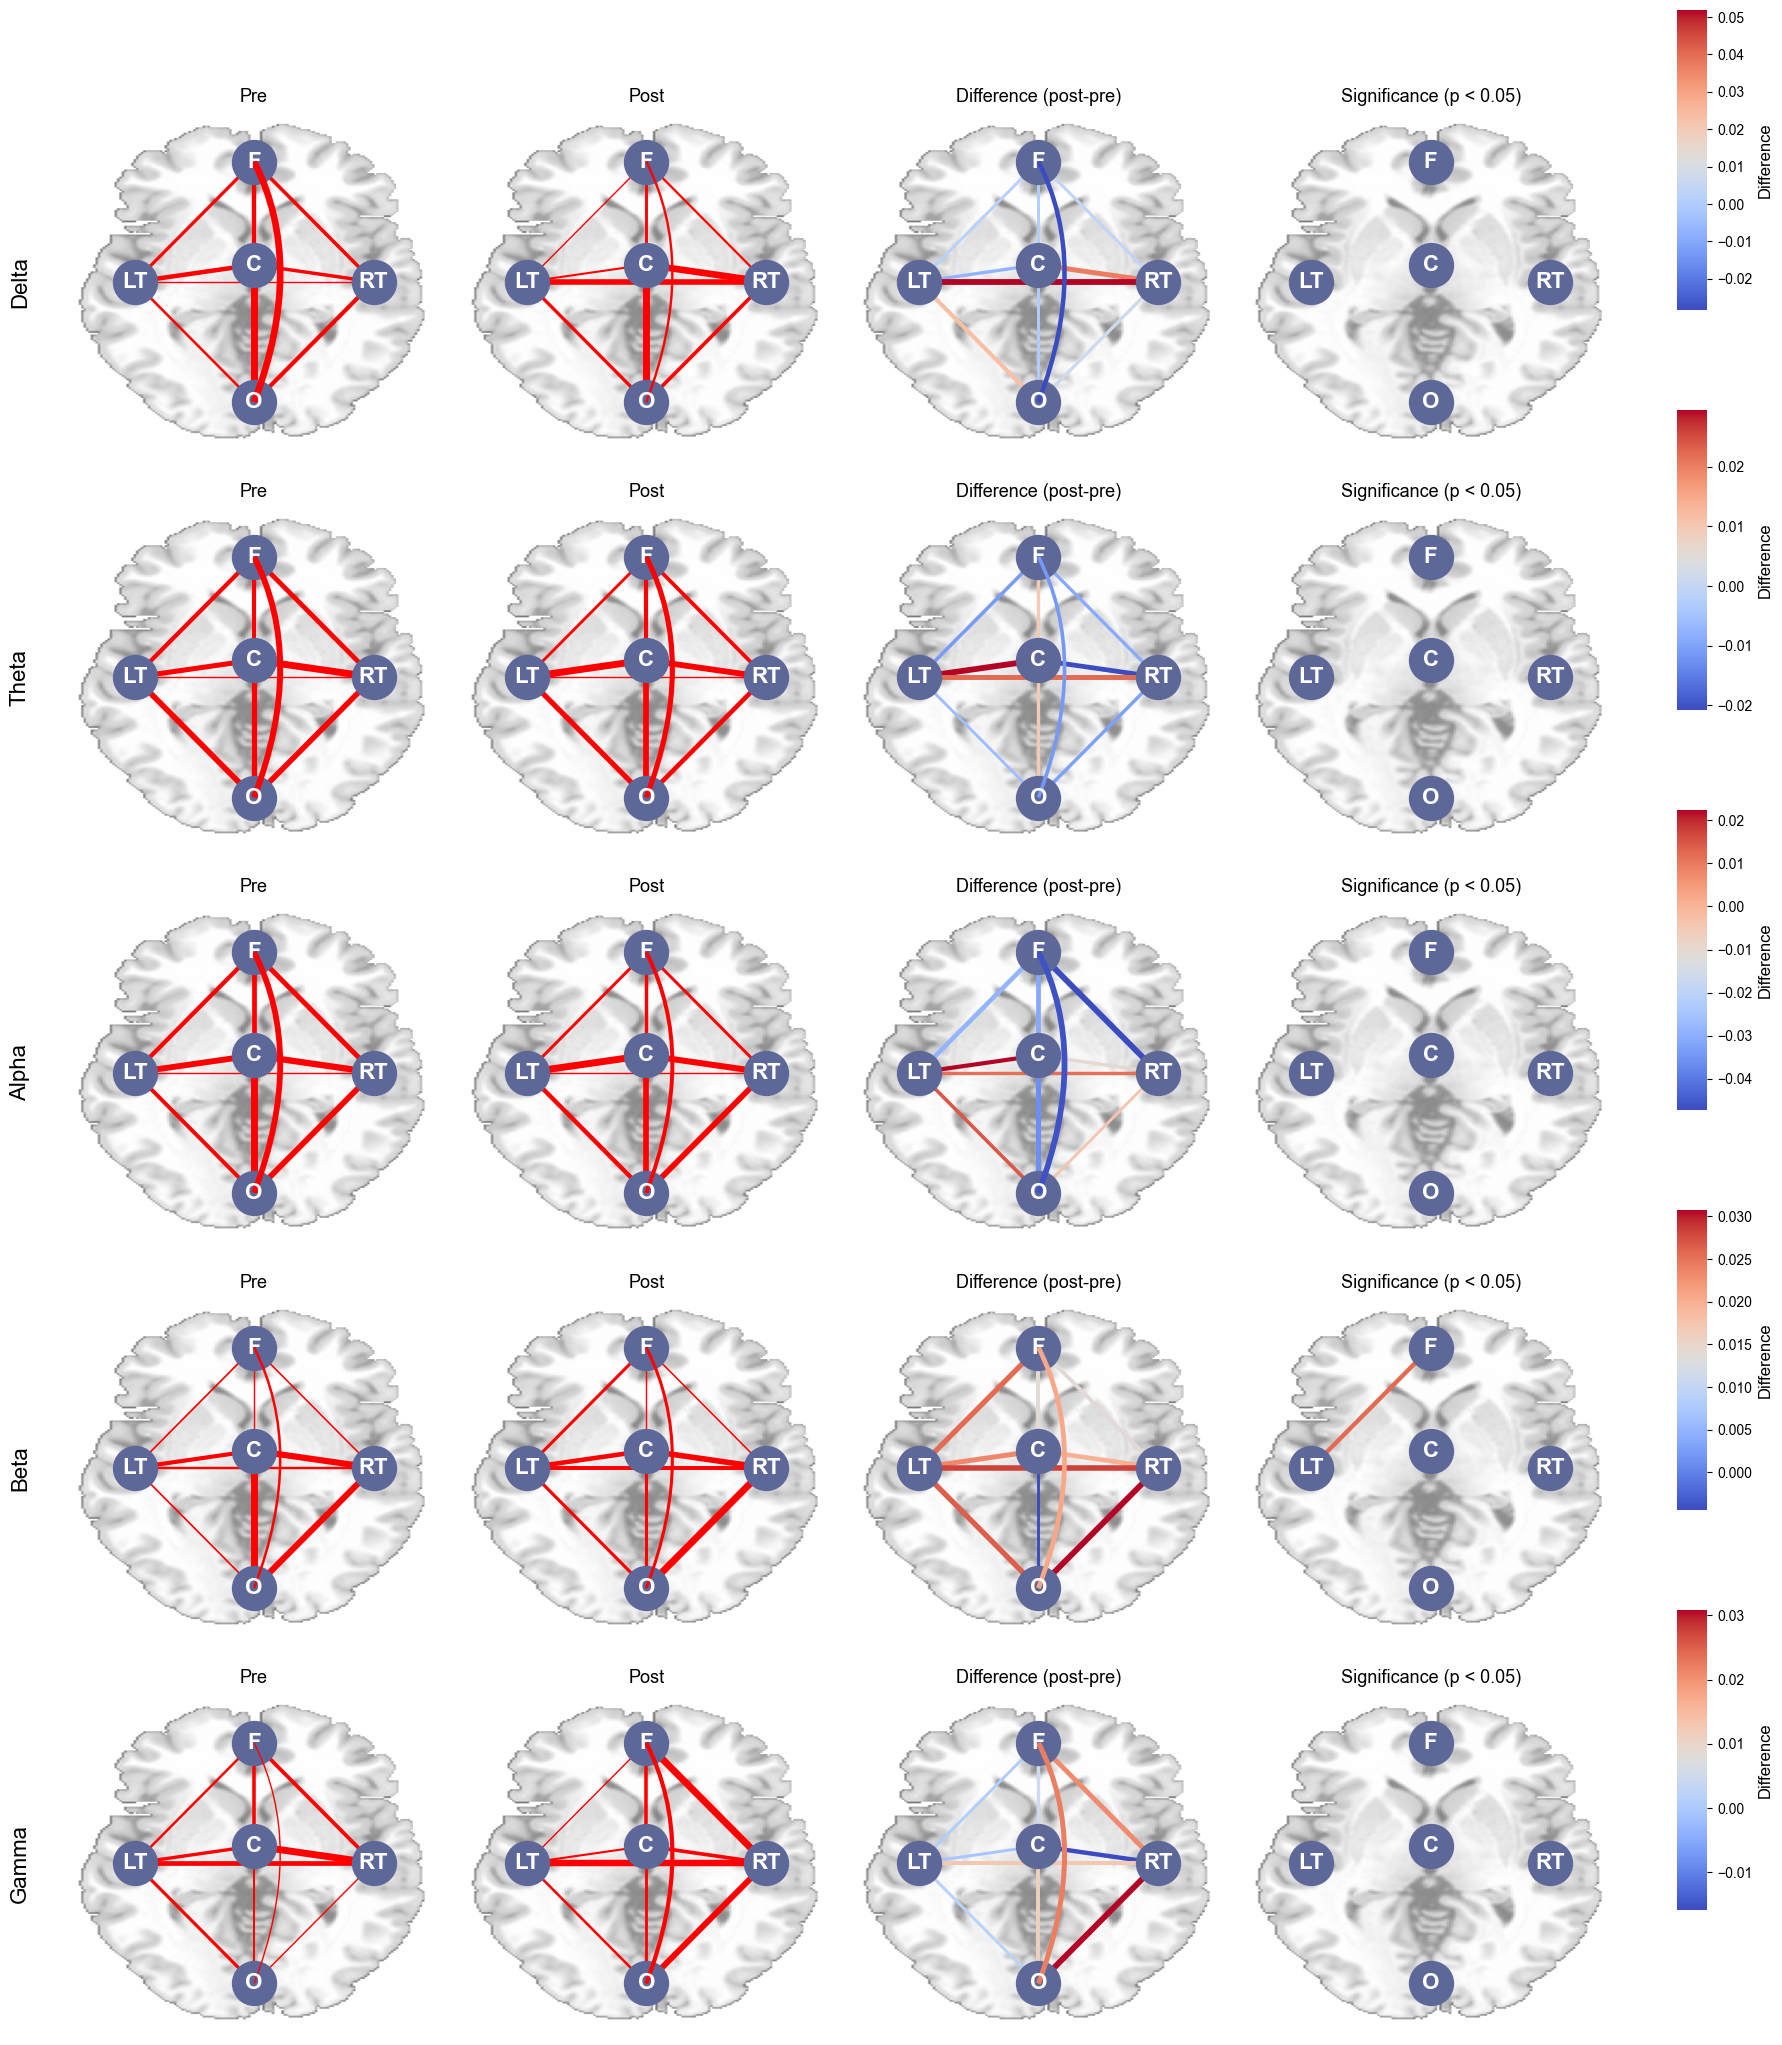

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy.stats import ttest_rel
import matplotlib as mpl

# --- 데이터 불러오기 및 필터링 ---
df = pd.read_csv('data_for_ROI.csv')
regions = ['Frontal', 'Central', 'LeftTemporal', 'RightTemporal', 'Occipital']
region_abbr = {'Frontal': 'F', 'Central': 'C', 'Occipital': 'O', 'LeftTemporal': 'LT', 'RightTemporal': 'RT'}
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

df = df[(df['etiology'].str.lower() == 'fcd')]
# df = df[(df['etiology'].str.lower() == 'tle')]

def extract_matrix_band(df, prefix, band, regions):
    mat = np.full((5, 5), np.nan)
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            if i < j or i == j:
                continue
            col1 = f'{prefix}{band}-{r1}-{r2}'
            col2 = f'{prefix}{band}-{r2}-{r1}'
            val = None
            if col1 in df.columns:
                val = df[col1].mean()
            elif col2 in df.columns:
                val = df[col2].mean()
            if val is not None:
                mat[i, j] = val
    for i in range(5):
        for j in range(i):
            mat[j, i] = mat[i, j]
    np.fill_diagonal(mat, 0)
    return mat

def extract_matrix_band_allsubs(df, prefix, band, regions):
    mats = []
    for idx, row in df.iterrows():
        mat = np.full((5, 5), np.nan)
        for i, r1 in enumerate(regions):
            for j, r2 in enumerate(regions):
                if i < j or i == j:
                    continue
                col1 = f'{prefix}{band}-{r1}-{r2}'
                col2 = f'{prefix}{band}-{r2}-{r1}'
                val = None
                if col1 in df.columns:
                    val = row[col1]
                elif col2 in df.columns:
                    val = row[col2]
                if not pd.isnull(val):
                    mat[i, j] = val
        for i in range(5):
            for j in range(i):
                mat[j, i] = mat[i, j]
        np.fill_diagonal(mat, 0)
        mats.append(mat)
    return np.array(mats)

def plot_brain_network(connectivity_matrix, title, ax, sig_mask=None, imgfile='brain_outline_transparent.png',
                       edge_cmap=None, vmin=None, vmax=None, node_color='#5D6899', edge_width_mode='strength',
                       min_width=1, max_width=5, frontal_occipital_curve=0.14):
    pos = {'Frontal': (0.5, 0.85), 'Central': (0.5, 0.55), 'Occipital': (0.5, 0.15),
           'LeftTemporal': (0.18, 0.5), 'RightTemporal': (0.82, 0.5)}
    G = nx.Graph()
    for name in regions:
        G.add_node(name)
    for i in range(len(regions)):
        for j in range(i+1, len(regions)):
            weight = connectivity_matrix[i, j]
            if not np.isnan(weight) and weight != 0:
                if sig_mask is None or sig_mask[i, j]:
                    G.add_edge(regions[i], regions[j], weight=weight)
    edges = G.edges(data=True)

    img = mpimg.imread(imgfile)
    ax.imshow(img, extent=[0, 1, 0, 1], aspect='auto', alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=1000, ax=ax)
    for node, (x, y) in pos.items():
        ax.text(x, y, region_abbr[node], ha='center', va='center', fontsize=16, color='white', fontfamily='Arial', fontweight='bold')

    all_weights = [abs(d['weight']) for (u, v, d) in edges]
    min_w, max_w = (min(all_weights), max(all_weights)) if all_weights else (0, 1)

    for (u, v, d) in edges:
        if set([u, v]) == set(['Frontal', 'Occipital']):
            continue
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        color = 'red' if edge_cmap is None else edge_cmap(mpl.colors.Normalize(vmin=vmin, vmax=vmax)(d['weight']))
        width = (min_width + (abs(d['weight']) - min_w) / (max_w - min_w) * (max_width - min_width)) if max_w > min_w else (min_width + max_width) / 2
        ax.plot([x0, x1], [y0, y1], color=color, linewidth=width, zorder=1)

    if G.has_edge('Frontal', 'Occipital'):
        x0, y0 = pos['Frontal']
        x1, y1 = pos['Occipital']
        xc, yc = pos['Central']
        ctrl_x, ctrl_y = xc + frontal_occipital_curve, yc
        path = Path([(x0, y0), (ctrl_x, ctrl_y), (x1, y1)], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
        color = 'red' if edge_cmap is None else edge_cmap(mpl.colors.Normalize(vmin=vmin, vmax=vmax)(connectivity_matrix[0,4]))
        w = abs(connectivity_matrix[0,4])
        width = (min_width + (w - min_w) / (max_w - min_w) * (max_width - min_width)) if max_w > min_w else (min_width + max_width) / 2
        ax.add_patch(patches.PathPatch(path, facecolor='none', lw=width, edgecolor=color, zorder=2))

    ax.set_title(title, fontsize=13, fontfamily='Arial')
    ax.axis('off')

# ---- 전체 Figure 설정 (5 bands x 4 panels) ----
fig, axes = plt.subplots(len(bands), 4, figsize=(20, 25))
plt.subplots_adjust(wspace=0.05, hspace=0.15)

for row, band in enumerate(bands):
    pre_mat = extract_matrix_band(df, 'pre_', band, regions)
    post_mat = extract_matrix_band(df, 'post_', band, regions)
    diff_mat = post_mat - pre_mat
    pre_all = extract_matrix_band_allsubs(df, 'pre_', band, regions)
    post_all = extract_matrix_band_allsubs(df, 'post_', band, regions)
    t_mat = np.full((5,5), np.nan)
    p_mat = np.full((5,5), np.nan)
    for i in range(5):
        for j in range(5):
            if i < j:
                continue
            x = pre_all[:,i,j]
            y = post_all[:,i,j]
            mask = ~np.isnan(x) & ~np.isnan(y)
            if np.sum(mask) > 1:
                t, p = ttest_rel(x[mask], y[mask])
                t_mat[i,j] = t
                p_mat[i,j] = p
    for i in range(5):
        for j in range(i):
            t_mat[j,i] = t_mat[i,j]
            p_mat[j,i] = p_mat[i,j]
    np.fill_diagonal(t_mat, 0)
    np.fill_diagonal(p_mat, 1)

    vmin = np.nanmin(diff_mat)
    vmax = np.nanmax(diff_mat)
    edge_cmap = mpl.cm.coolwarm

    plot_brain_network(pre_mat, 'Pre', axes[row, 0], node_color='#5D6899', edge_width_mode='strength', min_width=1, max_width=5)
    plot_brain_network(post_mat, 'Post', axes[row, 1], node_color='#5D6899', edge_width_mode='strength', min_width=1, max_width=5)
    plot_brain_network(diff_mat, 'Difference (post-pre)', axes[row, 2], edge_cmap=edge_cmap, vmin=vmin, vmax=vmax,
                       node_color='#5D6899', edge_width_mode='strength', min_width=2.1, max_width=4.2)
    plot_brain_network(diff_mat, 'Significance (p < 0.05)', axes[row, 3], sig_mask=(p_mat<0.05), edge_cmap=edge_cmap, vmin=vmin, vmax=vmax,
                       node_color='#5D6899', edge_width_mode='strength', min_width=2.1, max_width=4.2)
    axes[row, 0].text(-0.1, 0.5, band, va='center', ha='right', fontsize=16, fontfamily='Arial', rotation=90, transform=axes[row, 0].transAxes)

    # ---- 밴드별 colorbar 추가 ----
    cbar_ax = fig.add_axes([0.93, 0.8 - row * 0.16, 0.015, 0.12])  # 위치 조정
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=edge_cmap, norm=norm, orientation='vertical')
    cb1.set_label('Difference', fontsize=12, fontfamily='Arial')
    cb1.outline.set_visible(False)

fig.savefig('all_bands_network_with_individual_cbar-fcd.eps', dpi=600, bbox_inches='tight')
plt.show()